# End-to-End Machine Learning Project

## Get the Data

### Download the Data

In [1]:
import os
import tarfile
from six.moves import urllib
import ssl
import progressbar

from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork')

ssl._create_default_https_context = ssl._create_unverified_context

class ProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar = progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    print("Downloading...")
    urllib.request.urlretrieve(housing_url, tgz_path, ProgressBar())
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
# Download data
fetch_housing_data()

Downloading...


100% |########################################################################|


In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

### Take a Quick Look at the Data Structure

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


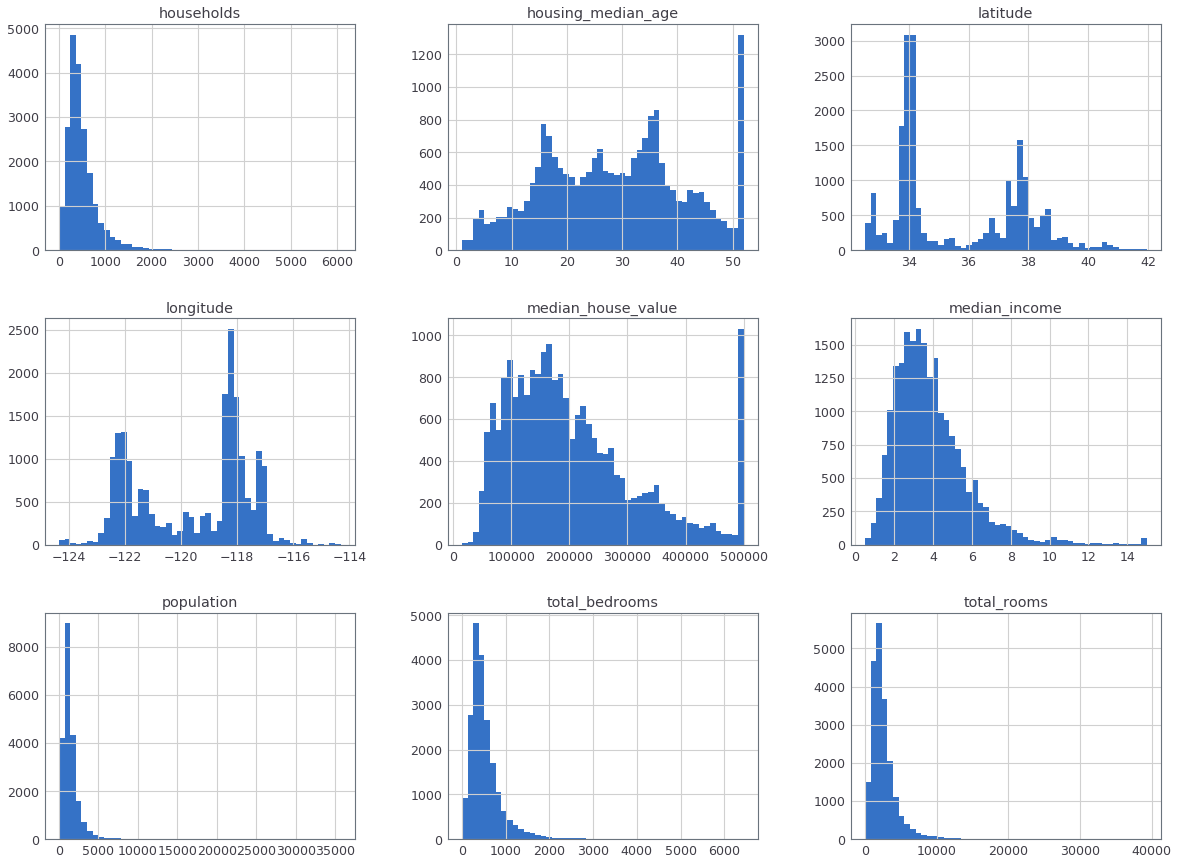

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
jtplot.style(theme='grade3')
housing.hist(bins=50, figsize=(20, 15))
plt.show()

### Create a Test Set

In [9]:
import numpy as np

""" Creating a test set is theoretically quite simple: just pick some instances
randomly, typically 20% of the dataset (or less if your dataset
is very large), and set them aside: """

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) # randomize indices
    test_set_size = int(len(data) * test_ratio) # calc size of test set
    test_indices = shuffled_indices[:test_set_size] # Take first items
    train_indices = shuffled_indices[test_set_size:] # Take last items
    
    return data.iloc[train_indices], data.iloc[test_indices]
    

In [10]:
# Use function above to split dataset
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [11]:
len(test_set)

4128

In [12]:
""" But split randomize the dataset is not the best solution:
"if you run the program again, it will generate a different test set"
A possible implementation to get always the same test set below: """

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index() # adds an `index` column
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [14]:
# Split by index column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
len(train_set)

16512

In [15]:
len(test_set)

4128

In [16]:
# Set id column from longitude and latitude
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

""" Obs: The location information is actually quite coarse, and as a result
many districts will have the exact same ID, so they will end up in the
same set (test or train). This introduces some unfortunate sampling bias """

housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


In [17]:
# Split by id column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

len(train_set)

16322

In [18]:
len(test_set)

4318

In [19]:
""" Split use sklearn lib which does pretty much 
the same thing as the function split_train_test defined earlier """
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
len(train_set)

16512

In [20]:
len(test_set)

4128

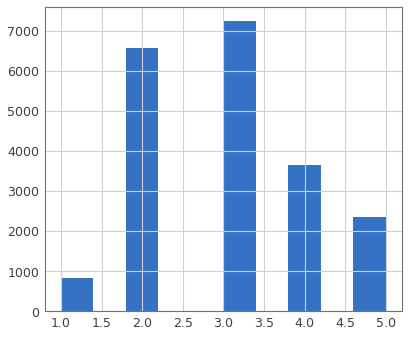

In [21]:
""" The following code uses the pd.cut() function to create an income
category attribute with 5 categories (labeled from 1 to 5):
category 1 # ranges from 0 to 1.5 (i.e., less than $15,000),
category 2 from 1.5 to 3, and so on: """

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [23]:
# Remove the income_cat attribute so the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

### Visualizing Geographical Data

In [24]:
# Copy train set to work only with it
housing = strat_train_set.copy()

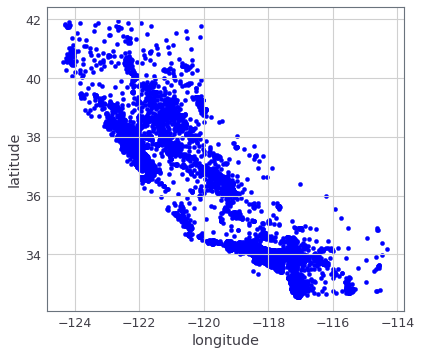

In [25]:
""" Since there is geographical information (latitude and longitude), it is a good idea to
create a scatterplot of all districts to visualize the data: """

housing.plot(kind="scatter", color="blue", x="longitude", y="latitude")

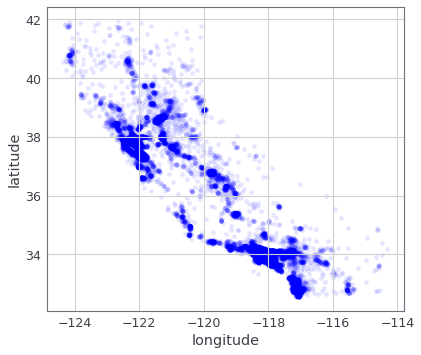

In [26]:
""" Setting the alpha option to 0.1 makes it much easier to visualize
the places where there is a high density of data points """
housing.plot(kind="scatter", color="blue", x="longitude", y="latitude", alpha="0.1")

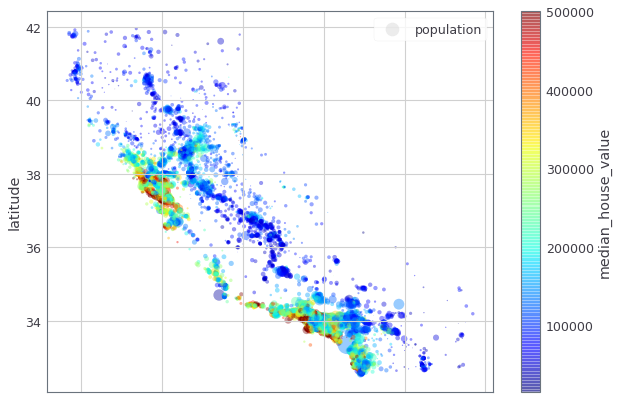

In [27]:
""" Now let’s look at the housing prices (Figure 2-13). The radius of each 
circle represents the district’s population (option s), 
and the color represents the price (option c). 
We will use a predefined color map (option cmap) called jet,
which ranges from blue (low values) to red (high prices): """

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()